# IST597 :recurrent neural networks for sequence classification with TensorFlow Eager
Thanks to @googleAI, @Keras, @madlalina @nvidia_research 
----

We will be  building a RNN for sentiment analysis on IMDB movie reviews ( [stanford_imdb](https://https://ai.stanford.edu/~amaas/data/sentiment/)). 


In [76]:
import tensorflow as tf
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
import sys
sys.path.insert(1,'/content/')
from data_utils import parse_imdb_sequence

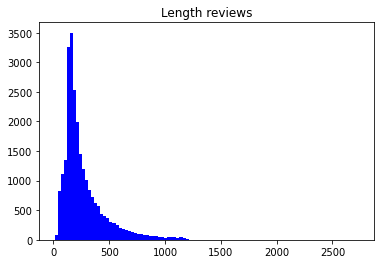

In [78]:
length_reviews = pickle.load(open('/content/length_reviews.pkl', 'rb'))
pd.DataFrame(length_reviews, columns=['Length reviews']).hist(bins=100, color='blue');
plt.grid(False);

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.2,shuffle=False, shuffle_size=10000):
    assert (train_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=5308)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds

In [81]:
import sys
# create a val set split here
train_dataset = tf.data.TFRecordDataset('/content/train.tfrecords')
ds_size = len(list(train_dataset))

train_dataset, validation_dataset = get_dataset_partitions_tf(train_dataset, ds_size)
#print (list(train_dataset)[0])
#print ((list(validation_dataset)[0]))
train_dataset = train_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
train_dataset = train_dataset.padded_batch(1024, padded_shapes=([None],[],[]))

validation_dataset = validation_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
validation_dataset = validation_dataset.padded_batch(1024, padded_shapes=([None],[],[]))
#print (list(train_dataset)[-1])
#print ((list(validation_dataset)[-1]))
test_dataset = tf.data.TFRecordDataset('/content/test.tfrecords')
test_dataset = test_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
test_dataset = test_dataset.padded_batch(64, padded_shapes=([None],[],[]))

In [82]:
len(list(train_dataset))

20

In [83]:
# Read the word vocabulary
word2idx = pickle.load(open('/content/word2idx.pkl', 'rb'))

## RNN model for sequence classification, compatible with Eager API 
----
In the cell below, you can find the class that I have created for the RNN model. The API is very similar with one I created in the previous tutorial, except that now we track the accuracy of the model instead of the loss.

The idea of the network is very simple. We simply take each word in the review, select its corresponding word embedding (initialized randomly in the beginning), and pass it through the RNN cell. We then take the output of the RNN cell at the end of the sequence and pass it through a dense layer (with ReLU activation) to obtain the final predictions. 

Like usually, the network inherits from tf.keras.Model in order to keep track of all variables and save/restore them easily.

![img](https://github.com/AnkurMali/IST597_SP21/blob/main/tutorials_graphics/rnn_imdb.png?raw=1)

In [84]:
from tensorflow.python.training import training
class RNNModel(tf.keras.Model):
    def __init__(self, embedding_size=100, cell_size=64, dense_size=128, 
                 num_classes=2, vocabulary_size=None, rnn_cell='lstm',
                 device='cpu:0', checkpoint_directory=None, dropout = False):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on and the checkpoint
            directory. Additionaly, you can also modify the default size of the 
            network.
            
            Args:
                embedding_size: the size of the word embedding.
                cell_size: RNN cell size.
                dense_size: the size of the dense layer.
                num_classes: the number of labels in the network.
                vocabulary_size: the size of the word vocabulary.
                rnn_cell: string, either 'lstm' or 'ugrnn'.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        '''
        super(RNNModel, self).__init__()
        self.dropout = dropout
        # Weights initializer function
        w_initializer = tf.compat.v1.keras.initializers.glorot_uniform()
    
        # Biases initializer function
        b_initializer = tf.zeros_initializer()
        
        # Initialize weights for word embeddings 
        self.embeddings = tf.keras.layers.Embedding(vocabulary_size, embedding_size, 
                                                    embeddings_initializer=w_initializer)
        
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size, activation=tf.nn.relu, 
                                                 kernel_initializer=w_initializer, 
                                                 bias_initializer=b_initializer)
        
        # Predictions layer initialization
        self.pred_layer = tf.keras.layers.Dense(num_classes, activation=None, 
                                                kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer)
        
        # Basic LSTM cell
        if rnn_cell=='lstm':
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)
        # Else RNN cell
        else:
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(cell_size)
            
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        
    def predict(self, X, seq_length, is_training):
        '''
        Predicts the probability of each class, based on the input sample.

        Args:
            X: 2D tensor of shape (batch_size, time_steps).
            seq_length: the length of each sequence in the batch.
            is_training: Boolean. Either the network is predicting in
                         training mode or not.
        '''
        
        # Get the number of samples within a batch
        num_samples = tf.shape(X)[0]

        # Initialize LSTM cell state with zeros
        state = self.rnn_cell.zero_state(num_samples, dtype=tf.float32)
        
        # Get the embedding of each word in the sequence
        embedded_words = self.embeddings(X)

        # Unstack the embeddings
        unstacked_embeddings = tf.unstack(embedded_words, axis=1)
        
        # Iterate through each timestep and append the predictions
        outputs = []
        for input_step in unstacked_embeddings:
            output, state = self.rnn_cell(input_step, state)
            outputs.append(output)
            
        # Stack outputs to (batch_size, time_steps, cell_size)
        outputs = tf.stack(outputs, axis=1)
        
        # Extract the output of the last time step, of each sample
        idxs_last_output = tf.stack([tf.range(num_samples), 
                                     tf.cast(seq_length-1, tf.int32)], axis=1)
        final_output = tf.gather_nd(outputs, idxs_last_output)
        
        # Add dropout for regularization
        if self.dropout and is_training:
          final_output = tf.nn.dropout(final_output, 0.8)
        
        #final_output = tf.compat.v1.layers.Dropout(final_output, rate=0.3, training=is_training)
        
        # Pass the last cell state through a dense layer (ReLU activation)
        dense = self.dense_layer(final_output)
        
        # Compute the unnormalized log probabilities
        logits = self.pred_layer(dense)
        return logits
    
    def loss_fn(self, X, y, seq_length, is_training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(X, seq_length, is_training)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=preds)
        return loss
    
    def grads_fn(self, X, y, seq_length, is_training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(X, y, seq_length, is_training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,1)))
            dummy_length = tf.constant(1, shape=(1,))
            dummy_pred = self.predict(dummy_input, dummy_length, False)
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
        
    def fit(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the accuracy on the eval 
                                       dataset does not increase after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best_acc. This variable will store the highest accuracy
        # on the eval dataset.
        best_acc = 0
        
        # Initialize classes to update the mean accuracy of train and eval
        train_acc = tf.keras.metrics.Accuracy('train_acc')
        eval_acc = tf.keras.metrics.Accuracy('eval_acc')
        
        # Initialize dictionary to store the accuracy history
        self.history = {}
        self.history['train_acc'] = []
        self.history['eval_acc'] = []
        
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for step, (X, y, seq_length) in enumerate(training_data):
                    grads = self.grads_fn(X, y, seq_length, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Check accuracy train dataset
                for step, (X, y, seq_length) in enumerate(training_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    train_acc(preds, y)
                self.history['train_acc'].append(train_acc.result().numpy())
                # Reset metrics
                train_acc.reset_states()

                # Check accuracy eval dataset
                for step, (X, y, seq_length) in enumerate(eval_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    eval_acc(preds, y)
                self.history['eval_acc'].append(eval_acc.result().numpy())
                # Reset metrics
                eval_acc.reset_states()
                
                # Print train and eval accuracy
                if (i==0) | ((i+1)%verbose==0):
                    print('Train accuracy at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    print('Eval accuracy at epoch %d: ' %(i+1), self.history['eval_acc'][-1])

                # Check for early stopping
                if self.history['eval_acc'][-1]>best_acc:
                    best_acc = self.history['eval_acc'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break  

## Train model with gradient descent and early stopping
----

### Model training with simple LSTM cells
----

In [85]:
# Train model
all_models = {}
#lstm_model.fit(train_dataset, test_dataset, optimizer, num_epochs=10, 
                #early_stopping_rounds=5, verbose=1, train_from_scratch=True)
import time
def train_model(model, train_dataset, validation_dataset, optimizer, num_epochs=10,early_stopping_rounds=5):
  time_start = time.time()
  model.fit(train_dataset, validation_dataset, optimizer, num_epochs, 
                  early_stopping_rounds, verbose=1, train_from_scratch=True)
  time_end = time.time()
  time_taken = time.time() - time_start
  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  return time_taken

In [86]:
def test_model(model):
  model.history['test_acc'] = []
  test_acc = tf.keras.metrics.Accuracy('test_acc')
  for step, (X, y, seq_length) in enumerate(test_dataset):
      logits = model.predict(X, seq_length, False)
      preds = tf.argmax(logits, axis=1)
      test_acc(preds, y)

  model.history['test_acc'].append(test_acc.result().numpy())
  print(f"Test accuracy {model.history['test_acc'][-1]}")

In [87]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/ImdbRNN/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model_adam = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.


In [88]:
time_taken_lstm_adam = train_model(lstm_model_adam, train_dataset, validation_dataset, optimizer, num_epochs=10,early_stopping_rounds=5)

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.837
Eval accuracy at epoch 1:  0.8166
Train accuracy at epoch 2:  0.9202
Eval accuracy at epoch 2:  0.871
Train accuracy at epoch 3:  0.96795
Eval accuracy at epoch 3:  0.8906
Train accuracy at epoch 4:  0.98885
Eval accuracy at epoch 4:  0.8886
Train accuracy at epoch 5:  0.99365
Eval accuracy at epoch 5:  0.8796
Train accuracy at epoch 6:  0.9967
Eval accuracy at epoch 6:  0.8758
Train accuracy at epoch 7:  0.999
Eval accuracy at epoch 7:  0.873
Train accuracy at epoch 8:  0.99955
Eval accuracy at epoch 8:  0.8726

Total time taken (in seconds): 319.18


In [89]:
# Save model
#lstm_model_adam.save_model()

In [90]:
test_model(lstm_model_adam)
all_models['lstm_model_adam'] = lstm_model_adam

Test accuracy 0.8485599756240845


### Model training with RNN cells 
---

In [91]:
# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model_adam = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn', 
                       device=device, checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.


In [92]:
# Train model
#ugrnn_model.fit(train_dataset, validation_dataset, optimizer, num_epochs=10, 
                #early_stopping_rounds=5, verbose=1, train_from_scratch=True)
time_taken_ugrnn_adam = train_model(ugrnn_model_adam, train_dataset, validation_dataset, optimizer, num_epochs=10,early_stopping_rounds=5)

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:459: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + self._num_units, self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:463: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.70445
Eval accuracy at epoch 1:  0.7022
Train accuracy at epoch 2:  0.89745
Eval accuracy at epoch 2:  0.8288
Train accuracy at epoch 3:  0.9148
Eval accuracy at epoch 3:  0.8502
Train accuracy at epoch 4:  0.9595
Eval accuracy at epoch 4:  0.8382
Train accuracy at epoch 5:  0.98175
Eval accuracy at epoch 5:  0.8502
Train accuracy at epoch 6:  0.99255
Eval accuracy at epoch 6:  0.8516
Train accuracy at epoch 7:  0.99665
Eval accuracy at epoch 7:  0.8482
Train accuracy at epoch 8:  0.99755
Eval accuracy at epoch 8:  0.8336
Train accuracy at epoch 9:  0.9987
Eval accuracy at epoch 9:  0.8392
Train accuracy at epoch 10:  0.99315
Eval accuracy at epoch 10:  0.8368

Total time taken (in seconds): 211.76


In [93]:
test_model(ugrnn_model_adam)
all_models['ugrnn_model_adam'] = ugrnn_model_adam

Test accuracy 0.8241599798202515


In [94]:
# Define optimizer.
#optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=1e-3)
optimizer = tf.optimizers.RMSprop(learning_rate=0.01)
# Instantiate model. This doesn't initialize the variables yet.
rmsprop_lstm_model = RNNModel(vocabulary_size=len(word2idx), 
                       device=device, checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.


In [95]:
# Train model
#rmsprop_lstm_model.fit(train_dataset, validation_dataset, optimizer, num_epochs=10, 
                #early_stopping_rounds=5, verbose=1, train_from_scratch=True)
time_taken_lstm_rmsprop = train_model(rmsprop_lstm_model, train_dataset, validation_dataset, optimizer, num_epochs=10,early_stopping_rounds=5)

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.65705
Eval accuracy at epoch 1:  0.6138
Train accuracy at epoch 2:  0.8507
Eval accuracy at epoch 2:  0.7322
Train accuracy at epoch 3:  0.82865
Eval accuracy at epoch 3:  0.6966
Train accuracy at epoch 4:  0.9082
Eval accuracy at epoch 4:  0.6856
Train accuracy at epoch 5:  0.95375
Eval accuracy at epoch 5:  0.7366
Train accuracy at epoch 6:  0.9807
Eval accuracy at epoch 6:  0.7352
Train accuracy at epoch 7:  0.98685
Eval accuracy at epoch 7:  0.7284
Train accuracy at epoch 8:  0.99435
Eval accuracy at epoch 8:  0.736
Train accuracy at epoch 9:  0.9962
Eval accuracy at epoch 9:  0.7186
Train accuracy at epoch 10:  0.998
Eval accuracy at epoch 10:  0.7274

Total time taken (in seconds): 399.94


In [96]:
test_model(rmsprop_lstm_model)
all_models['rmsprop_lstm_model'] = rmsprop_lstm_model

Test accuracy 0.7240399718284607


In [97]:
# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

# Instantiate model. This doesn't initialize the variables yet.
ugrnn_dropout_adam_model = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn', 
                       device=device, checkpoint_directory=checkpoint_directory, dropout=True)

time_taken_ugrnn_dropout_adam = train_model(ugrnn_dropout_adam_model, train_dataset, validation_dataset, optimizer, num_epochs=10,early_stopping_rounds=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:459: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + self._num_units, self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:463: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.7711
Eval accuracy at epoch 1:  0.751
Train accuracy at epoch 2:  0.88455
Eval accuracy at epoch 2:  0.8524
Train accuracy at epoch 3:  0.94675
Eval accuracy at epoch 3:  0.8672
Train accuracy at epoch 4:  0.97605
Eval accuracy at epoch 4:  0.8682
Train accuracy at epoch 5:  0.98785
Eval accuracy at epoch 5:  0.863
Train accuracy at epoch 6:  0.99305
Eval accuracy at epoch 6:  0.866
Train accuracy at epoch 7:  0.99555
Eval accuracy at epoch 7:  0.8608
Train accuracy at epoch 8:  0.979
Eval accuracy at epoch 8:  0.8226
Train accuracy at epoch 9:  0.98995
Eval accuracy at epoch 9:  0.8572

Total time taken (in seconds): 190.25


In [98]:
test_model(ugrnn_dropout_adam_model)
all_models['ugrnn_dropout_adam_model'] = ugrnn_dropout_adam_model

Test accuracy 0.8343200087547302


In [99]:
# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

# Instantiate model. This doesn't initialize the variables yet.
lstm_dropout_adam_model = RNNModel(vocabulary_size=len(word2idx),  
                       device=device, checkpoint_directory=checkpoint_directory, dropout=True)

time_taken_lstm_dropout_adam = train_model(lstm_dropout_adam_model, train_dataset, validation_dataset, optimizer, num_epochs=10,early_stopping_rounds=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.63625
Eval accuracy at epoch 1:  0.6246
Train accuracy at epoch 2:  0.88955
Eval accuracy at epoch 2:  0.8508
Train accuracy at epoch 3:  0.94175
Eval accuracy at epoch 3:  0.8786
Train accuracy at epoch 4:  0.97785
Eval accuracy at epoch 4:  0.8888
Train accuracy at epoch 5:  0.99005
Eval accuracy at epoch 5:  0.8852
Train accuracy at epoch 6:  0.9949
Eval accuracy at epoch 6:  0.8822
Train accuracy at epoch 7:  0.9962
Eval accuracy at epoch 7:  0.8734
Train accuracy at epoch 8:  0.99875
Eval accuracy at epoch 8:  0.8794
Train accuracy at epoch 9:  0.99875
Eval accuracy at epoch 9:  0.8764

Total time taken (in seconds): 358.74


In [101]:
test_model(lstm_dropout_adam_model)
all_models['lstm_dropout_adam_model'] = lstm_dropout_adam_model

Test accuracy 0.8428400158882141


### Performance comparison
---

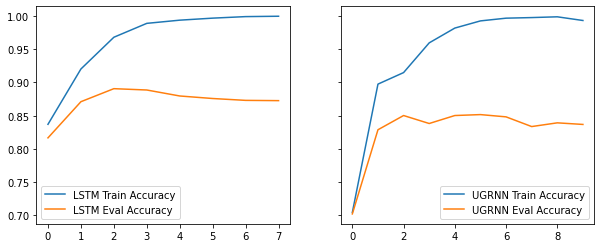

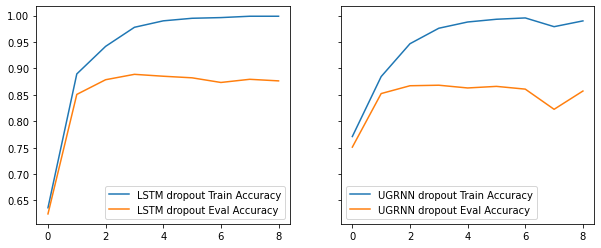

In [102]:
f, (ax1, ax2) = plt.subplots(1, 2,sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model_adam.history['train_acc'])), lstm_model_adam.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model_adam.history['eval_acc'])), lstm_model_adam.history['eval_acc'], 
         label='LSTM Eval Accuracy');

ax2.plot(range(len(ugrnn_model_adam.history['train_acc'])), ugrnn_model_adam.history['train_acc'],
         label='UGRNN Train Accuracy');
ax2.plot(range(len(ugrnn_model_adam.history['eval_acc'])), ugrnn_model_adam.history['eval_acc'],
         label='UGRNN Eval Accuracy');

f, (ax3, ax4) = plt.subplots(1, 2,sharey=True, figsize=(10, 4))
ax3.plot(range(len(lstm_dropout_adam_model.history['train_acc'])), lstm_dropout_adam_model.history['train_acc'],
         label='LSTM dropout Train Accuracy');
ax3.plot(range(len(lstm_dropout_adam_model.history['eval_acc'])), lstm_dropout_adam_model.history['eval_acc'],
         label='LSTM dropout Eval Accuracy');
ax4.plot(range(len(ugrnn_dropout_adam_model.history['train_acc'])), ugrnn_dropout_adam_model.history['train_acc'],
        label='UGRNN dropout Train Accuracy');
ax4.plot(range(len(ugrnn_dropout_adam_model.history['eval_acc'])), ugrnn_dropout_adam_model.history['eval_acc'],
         label='UGRNN dropout Eval Accuracy');
ax1.legend();
ax2.legend();
ax3.legend();
ax4.legend();

## Test network on new samples
---



In [103]:
################################################################
# Restore trained model
################################################################
'''
tf.reset_default_graph()
checkpoint_directory = 'models_checkpoints/ImdbRNN/'
device = 'gpu:0' 
lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)
lstm_model.restore_model()
'''

"\ntf.reset_default_graph()\ncheckpoint_directory = 'models_checkpoints/ImdbRNN/'\ndevice = 'gpu:0' \nlstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, \n                      checkpoint_directory=checkpoint_directory)\nlstm_model.restore_model()\n"

In [104]:
###############################################################
# Import/download necessary libraries to process new sequences
###############################################################

import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re


In [105]:
def process_new_review(review):
    '''Function to process a new review.
       Args:
           review: original text review, string.
       Returns:
           indexed_review: sequence of integers, words correspondence 
                           from word2idx.
           seq_length: the length of the review.
    '''
    indexed_review = re.sub(r'<[^>]+>', ' ', review)
    indexed_review = word_tokenize(indexed_review)
    indexed_review = [word2idx[word] if word in list(word2idx.keys()) else 
                      word2idx['Unknown_token'] for word in indexed_review]
    indexed_review = indexed_review + [word2idx['End_token']]
    seq_length = len(indexed_review)    
    return indexed_review, seq_length

In [106]:
sent_dict = {0: 'negative', 1: 'positive'}

In [107]:
review_score_10 = "I think Bad Apples is a great time and I recommend! I enjoyed the opening, which gave way for the rest of the movie to occur. The main couple was very likable and I believed all of their interactions. They had great onscreen chemistry and made me laugh quite a few times! Keeping the girls in the masks but seeing them in action was something I loved. It kept a mystery to them throughout. I think the dialogue was great. The kills were fun. And the special surprise gore effect at the end was AWESOME!! I won't spoil that part ;) I also enjoyed how the movie wrapped up. It gave a very urban legends type feel of \"did you ever hear the story...\". Plus is leaves the door open for another film which I wouldn't mind at all. Long story short, I think if you take the film for what it is; a fun little horror flick, then you won't be disappointed! HaPpY eArLy HaLLoWeEn!"

In [108]:
review_score_4 = "A young couple comes to a small town, where the husband get a job working in a hospital. The wife which you instantly hate or dislike works home, at the same time a horrible murders takes place in this small town by two masked killers. Bad Apples is just your tipical B-horror movie with average acting (I give them that. Altough you may get the idea that some of the actors are crazy-convervative Christians), but the script is just bad, and that's what destroys the film."

In [109]:
review_score_1 = "When you first start watching this movie, you can tell its going to be a painful ride. the audio is poor...the attacks by the \"girls\" are like going back in time, to watching the old rocky films, were blows never touched. the editing is poor with it aswell, example the actress in is the bath when her husband comes home, clearly you see her wearing a flesh coloured bra in the bath. no hints or spoilers, just wait till you find it in a bargain basket of cheap dvds in a couple of weeks"
review_score_11 = "Hailed as a classic, but oddly unengaging and Nicholson doesn't help"
review_score_21 = "The movie was meh."
review_score_22 = "The movie was dull and drowsy"
review_score_23 = "It was a WOW movie"

In [110]:
new_reviews = [review_score_10, review_score_4, review_score_1, review_score_11, review_score_21,review_score_22,review_score_23]
scores = [10, 4, 1, 11, 21, 22, 23]

In [111]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = lstm_model_adam.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

The sentiment for the review with score 10 was found to be positive
The sentiment for the review with score 4 was found to be negative
The sentiment for the review with score 1 was found to be negative
The sentiment for the review with score 11 was found to be negative
The sentiment for the review with score 21 was found to be negative
The sentiment for the review with score 22 was found to be negative
The sentiment for the review with score 23 was found to be positive


In [112]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = ugrnn_model_adam.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

The sentiment for the review with score 10 was found to be positive
The sentiment for the review with score 4 was found to be negative
The sentiment for the review with score 1 was found to be negative
The sentiment for the review with score 11 was found to be positive
The sentiment for the review with score 21 was found to be negative
The sentiment for the review with score 22 was found to be negative
The sentiment for the review with score 23 was found to be positive


In [113]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = rmsprop_lstm_model.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

The sentiment for the review with score 10 was found to be positive
The sentiment for the review with score 4 was found to be negative
The sentiment for the review with score 1 was found to be positive
The sentiment for the review with score 11 was found to be positive
The sentiment for the review with score 21 was found to be positive
The sentiment for the review with score 22 was found to be negative
The sentiment for the review with score 23 was found to be positive


In [114]:
print (all_models)

{'lstm_model_adam': <__main__.RNNModel object at 0x7f029a095610>, 'ugrnn_model_adam': <__main__.RNNModel object at 0x7f0300033b50>, 'rmsprop_lstm_model': <__main__.RNNModel object at 0x7f03165f4190>, 'ugrnn_dropout_adam_model': <__main__.RNNModel object at 0x7f029a1f86d0>, 'lstm_dropout_adam_model': <__main__.RNNModel object at 0x7f0316753310>}


In [115]:
time_taken_lstm_adam

319.1764781475067

In [116]:
time_taken_lstm_dropout_adam

358.74462509155273

In [117]:
time_taken_lstm_rmsprop

399.9376394748688

In [118]:
time_taken_lstm_dropout_adam

358.74462509155273

In [119]:
time_taken_ugrnn_adam

211.75835967063904

In [120]:
time_taken_ugrnn_dropout_adam

190.24637842178345

In [121]:
all_models

{'lstm_dropout_adam_model': <__main__.RNNModel at 0x7f0316753310>,
 'lstm_model_adam': <__main__.RNNModel at 0x7f029a095610>,
 'rmsprop_lstm_model': <__main__.RNNModel at 0x7f03165f4190>,
 'ugrnn_dropout_adam_model': <__main__.RNNModel at 0x7f029a1f86d0>,
 'ugrnn_model_adam': <__main__.RNNModel at 0x7f0300033b50>}

In [126]:
keys = all_models.keys()
for key in keys:
  print (f"{key}: {list(all_models[key].history['test_acc'])[0]}")

lstm_model_adam: 0.8485599756240845
ugrnn_model_adam: 0.8241599798202515
rmsprop_lstm_model: 0.7240399718284607
ugrnn_dropout_adam_model: 0.8343200087547302
lstm_dropout_adam_model: 0.8428400158882141


In [130]:
keys = all_models.keys()
for key in keys:
  print (f"{key}: {list(all_models[key].history['train_acc'])}")

lstm_model_adam: [0.837, 0.9202, 0.96795, 0.98885, 0.99365, 0.9967, 0.999, 0.99955]
ugrnn_model_adam: [0.70445, 0.89745, 0.9148, 0.9595, 0.98175, 0.99255, 0.99665, 0.99755, 0.9987, 0.99315]
rmsprop_lstm_model: [0.65705, 0.8507, 0.82865, 0.9082, 0.95375, 0.9807, 0.98685, 0.99435, 0.9962, 0.998]
ugrnn_dropout_adam_model: [0.7711, 0.88455, 0.94675, 0.97605, 0.98785, 0.99305, 0.99555, 0.979, 0.98995]
lstm_dropout_adam_model: [0.63625, 0.88955, 0.94175, 0.97785, 0.99005, 0.9949, 0.9962, 0.99875, 0.99875]


In [131]:
keys = all_models.keys()
for key in keys:
  print (f"{key}: {list(all_models[key].history['eval_acc'])}")

lstm_model_adam: [0.8166, 0.871, 0.8906, 0.8886, 0.8796, 0.8758, 0.873, 0.8726]
ugrnn_model_adam: [0.7022, 0.8288, 0.8502, 0.8382, 0.8502, 0.8516, 0.8482, 0.8336, 0.8392, 0.8368]
rmsprop_lstm_model: [0.6138, 0.7322, 0.6966, 0.6856, 0.7366, 0.7352, 0.7284, 0.736, 0.7186, 0.7274]
ugrnn_dropout_adam_model: [0.751, 0.8524, 0.8672, 0.8682, 0.863, 0.866, 0.8608, 0.8226, 0.8572]
lstm_dropout_adam_model: [0.6246, 0.8508, 0.8786, 0.8888, 0.8852, 0.8822, 0.8734, 0.8794, 0.8764]


In [135]:
for review in new_reviews:
  print (review)

I think Bad Apples is a great time and I recommend! I enjoyed the opening, which gave way for the rest of the movie to occur. The main couple was very likable and I believed all of their interactions. They had great onscreen chemistry and made me laugh quite a few times! Keeping the girls in the masks but seeing them in action was something I loved. It kept a mystery to them throughout. I think the dialogue was great. The kills were fun. And the special surprise gore effect at the end was AWESOME!! I won't spoil that part ;) I also enjoyed how the movie wrapped up. It gave a very urban legends type feel of "did you ever hear the story...". Plus is leaves the door open for another film which I wouldn't mind at all. Long story short, I think if you take the film for what it is; a fun little horror flick, then you won't be disappointed! HaPpY eArLy HaLLoWeEn!
A young couple comes to a small town, where the husband get a job working in a hospital. The wife which you instantly hate or disli

In [143]:
new_reviews_1 = [review_score_11,review_score_21]
scores_1 = [1,2]
with tf.device(device):
    for original_review, score in zip(new_reviews_1, scores_1):
      print (f"Testing review : {original_review}")
      for key in keys:
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = all_models[key].predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('Model : %s - sentiment : %s'
              %(key, sent_dict[pred]))
      print()

Testing review : Hailed as a classic, but oddly unengaging and Nicholson doesn't help
Model : lstm_model_adam - sentiment : negative
Model : ugrnn_model_adam - sentiment : positive
Model : rmsprop_lstm_model - sentiment : positive
Model : ugrnn_dropout_adam_model - sentiment : positive
Model : lstm_dropout_adam_model - sentiment : positive

Testing review : The movie was meh.
Model : lstm_model_adam - sentiment : negative
Model : ugrnn_model_adam - sentiment : negative
Model : rmsprop_lstm_model - sentiment : positive
Model : ugrnn_dropout_adam_model - sentiment : negative
Model : lstm_dropout_adam_model - sentiment : negative

